Let's import all the libraries and classes we will need while making this project

In [0]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.regularizers import Regularizer

import tensorflow.keras.utils as ku 
import numpy as np 

# Importing Data

Now we will read the data. I'm reading the data from my github profile link, you can directly use txt files. 

In [0]:
import urllib.request

url = "https://raw.githubusercontent.com/ishantjuyal/Word-Prediction/master/Data/Taylor_Swift.txt"
data = urllib.request.urlopen(url).read().decode("utf-8")

In [0]:
len(data)

178471

In [0]:
data

'lyric\r\nHe said the way my blue eyes shined\r\nPut those Georgia stars to shame that night\r\nI said, "That\'s a lie"\r\nJust a boy in a Chevy truck\r\nThat had a tendency of gettin\' stuck\r\nOn backroads at night\r\nAnd I was right there beside him all summer long\r\nAnd then the time we woke up to find that summer gone\r\nBut when you think Tim McGraw\r\nI hope you think my favorite song\r\nThe one we danced to all night long\r\nThe moon like a spotlight on the lake\r\nWhen you think happiness\r\nI hope you think that little black dress\r\nThink of my head on your chest\r\nAnd my old faded blue jeans\r\nWhen you think Tim McGraw\r\nI hope you think of me\r\nSeptember saw a month of tears\r\nAnd thankin\' God that you weren\'t here\r\nTo see me like that\r\nBut in a box beneath my bed\r\nIs a letter that you never read\r\nFrom three summers back\r\nIt\'s hard not to find it all a little bittersweet\r\nAnd lookin\' back on all of that, it\'s nice to believe\r\nWhen you think Tim McG

Now we will convert data, which is a string to a list containing differrent sentences. 
As we can see, in the string, "end of line" is represented by "\r\n". So, we will split the string by "\r\n" and store them as list in corpus.

In [0]:
# Splitting the string into sentences, while converting whole data into lowercase. 
corpus = data.lower().split("\r\n")

# Now, to make sure no sentence appears twice in our corpus, we use set. Otherwise, it will make the model biased.
corpus = list(set(corpus))

Let's see how an element of corpus looks like. 

In [0]:
corpus[3]

'lurking in the shadows with their lip gloss smiles'

As we can see, it is just a sentence without any "\r or \n"

# Organising Data
Now we will use Tokenizer to convert the words to word vectors. 
Our model understands numbers only, so we need to give it numbers instead of words. 

In [0]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

In [0]:
print("Input Sequences")
print(input_sequences)
print("*****")
print("Shape of Input Sequences", input_sequences.shape)

Input Sequences
[[   0    0    0 ...    0    3    4]
 [   0    0    0 ...    3    4  901]
 [   0    0    0 ...    4  901  109]
 ...
 [   0    0    0 ...    8   13    7]
 [   0    0    0 ...   13    7  101]
 [   0    0    0 ...    7  101 2408]]
*****
Shape of Input Sequences (20384, 18)


In [0]:
print("Predictors")
print(predictors)
print('*****')
print("Shape of predictors is", predictors.shape)

Predictors
[[  0   0   0 ...   0   0   3]
 [  0   0   0 ...   0   3   4]
 [  0   0   0 ...   3   4 901]
 ...
 [  0   0   0 ... 232   8  13]
 [  0   0   0 ...   8  13   7]
 [  0   0   0 ...  13   7 101]]
*****
Shape of predictors is (20384, 17)


In [0]:
print("Label")
print(label)
print("*****")
print("Shape of label", label.shape)

Label
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
*****
Shape of label (20384, 2409)


Now, we will start building model using Keras. We use LSTM so that our model could be more accurate and inderstand the context better. 

In [0]:
model = Sequential()
model.add(Embedding(total_words, 50, input_length=max_sequence_len-1))  #(# Embedding Layer)
model.add(Bidirectional(LSTM(150, return_sequences=True)))  #(An LSTM Layer)
model.add(Dropout(0.2))  #(# A dropout layer for regularisation)
model.add(LSTM(100))  #(# Another LSTM Layer)
model.add(Dense(total_words/2, activation='relu'))  #(# A Dense Layer including regularizers)
#(# Last Layer, the shape is equal to total number of words present in our vocabulary)
model.add(Dense(total_words, activation='softmax'))  
# Pick an optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')  #(# Pick a loss function and an optimizer)
print(model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 17, 50)            120450    
_________________________________________________________________
bidirectional (Bidirectional (None, 17, 300)           241200    
_________________________________________________________________
dropout (Dropout)            (None, 17, 300)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1204)              121604    
_________________________________________________________________
dense_1 (Dense)              (None, 2409)              2902845   
Total params: 3,546,499
Trainable params: 3,546,499
Non-trainable params: 0
______________________________________________

In [0]:
history = model.fit(predictors, label, epochs= 125, verbose=1)

Epoch 1/125
637/637 [==============================] - 19s 29ms/step - loss: 6.1419 - accuracy: 0.0464
Epoch 2/125
637/637 [==============================] - 18s 29ms/step - loss: 5.6784 - accuracy: 0.0574
Epoch 3/125
637/637 [==============================] - 19s 29ms/step - loss: 5.4677 - accuracy: 0.0590
Epoch 4/125
637/637 [==============================] - 19s 29ms/step - loss: 5.3045 - accuracy: 0.0692
Epoch 5/125
637/637 [==============================] - 19s 29ms/step - loss: 5.1348 - accuracy: 0.0873
Epoch 6/125
637/637 [==============================] - 18s 29ms/step - loss: 4.9654 - accuracy: 0.1016
Epoch 7/125
637/637 [==============================] - 19s 29ms/step - loss: 4.8137 - accuracy: 0.1176
Epoch 8/125
637/637 [==============================] - 19s 29ms/step - loss: 4.6863 - accuracy: 0.1242
Epoch 9/125
637/637 [==============================] - 19s 29ms/step - loss: 4.5457 - accuracy: 0.1369
Epoch 10/125
637/637 [==============================] - 18s 29ms/step - l

Now, we will see how our model performed with each iteration. 

In [0]:
import matplotlib.pyplot as plt

def plot_graph(history,string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()

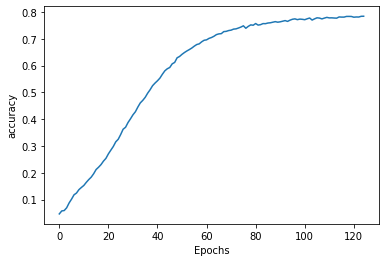

In [0]:
plot_graph(history,'accuracy')

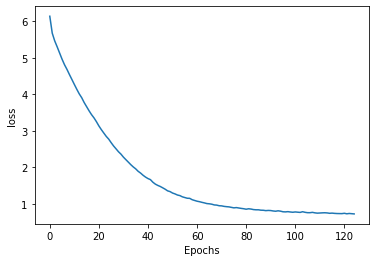

In [0]:
plot_graph(history,'loss')

# Generate Lyrics

In [0]:
def make_lyrics(seed_text, next_words):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = model.predict_classes(token_list, verbose=0)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word
    print(seed_text)

In [0]:
make_lyrics("How", 12)

How you kissed me when i was in the middle of saying something


In [0]:
make_lyrics("Hello", 8)

Hello to you and your temper days was someday


In [0]:
make_lyrics("Light", 8)

Light me up light me up light me up


In [0]:
make_lyrics("Walking", 10)

Walking through a crowd the village is aglow you can know
